# Find periodic variables in ComCam data

## Installation

In [17]:
# %pip install lsdb dask nested-dask astropy light-curve

# Importing

In [1]:
import lsdb
from lsdb import read_hats
import dask
import pandas as pd
from pathlib import Path
import light_curve as licu
import numpy as np
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import LombScargle as LombScargle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from dask.distributed import Client
from nested_pandas import NestedDtype
import numpy as np

from pathlib import Path

os.environ["NUMEXPR_MAX_THREADS"] = "32"  # Set to the maximum number of threads you want to allow
os.environ["NUMEXPR_NUM_THREADS"] = "32"   # Set to the number of threads to actually use
dask.config.set({"dataframe.convert-string": False})

print(lsdb.__version__)
print(pd.__version__)

COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


0.5.0
2.2.3


In [80]:
# Load the Forced Source + MJD Table
release = 'w_2025_09'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats/") / release
# list dir
print(list(map(str, hats_path.iterdir())))

comcam_obj = hats_path / "object_lc"

obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec", "forcedSource"],
)

def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )
    
obj = obj.map_partitions(cast_nested, columns=["forcedSource"])

['/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/diaObject_lc_index', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object_lc', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object_lc_5arcs', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/diaObject_lc_5arcs', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object_lc_x_ztf_dr22', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object_lc_x_ps1', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/diaObject_lc', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object_lc_index', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/diaSource', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/forcedSource', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/diaObject_lc_x_ps1', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/source', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_09/object', '/sdf/data/rubin/shared/lsdb_comm

In [81]:
obj_small = obj.head(5)
obj_small

objectId   coord_ra  coord_dec  \
_healpix_29                                                   
9193715628025022  4601676064568115495  38.157134   5.970823   
9193715786527588  4496114152208596993  38.160925   5.970709   
9193715787902489  4601676064568115201  38.160876   5.970707   
9193715787917295  4602155451637826209   38.16089   5.970716   
9193715787942426  4602151053591314777  38.160878   5.970718   

                                                       forcedSource  
_healpix_29                                                          
9193715628025022  [{parentObjectId: 0, coord_ra: 38.157134, coor...  
9193715786527588  [{parentObjectId: 0, coord_ra: 38.160925, coor...  
9193715787902489  [{parentObjectId: 0, coord_ra: 38.160876, coor...  
9193715787917295  [{parentObjectId: 0, coord_ra: 38.16089, coord...  
9193715787942426  [{parentObjectId: 0, coord_ra: 38.160878, coor...

# Function

In [82]:
periodogram_extractor = licu.Periodogram(
    peaks=10,
    nyquist='average',
    resolution=100_000,
    max_freq_factor=1,
    fast=False,
)
reduced_chi2_extractor = licu.ReducedChi2()

MAX_PERIOD = 1  # days
MIN_PERIOD = 1 / 24
BAD_PERIODS = np.array([1/3, 0.5, 2/3, 1, 2, 29.5])
# BAD_PERIODS = np.array([])
BAD_PERIOD_REL_RANGE = 10 / 365.2422

def filter_periods(periods):
    periods = np.asarray(periods)
    return (
        np.all(np.abs(periods[:, None]/BAD_PERIODS - 1.0) > BAD_PERIOD_REL_RANGE, axis=1)
        & (periods >= MIN_PERIOD) 
        & (periods <= MAX_PERIOD)
    )
    
BANDS = 'gri'
MIN_NOBS_BAND=25
def extract_period_singleband_licu(band, t, mag, magerr, **kwargs):   
    # del magerr  # unused
    try:
        BANDS = 'r'
        periods = []
        s2n = []
        for b in BANDS:

            band_index = band == b
            band_t, band_mag = t[band_index], mag[band_index]

            if len(band_t) < MIN_NOBS_BAND:
                continue
            if np.std(band_mag) <0.01:
                continue
            print(f"Extracting period for band {b} with {len(band_t)} observations")
            print(band_t)
            print(band_mag)
            features = periodogram_extractor(band_t, band_mag, **kwargs)
            periods.extend(features[::2])
            s2n.extend(features[1::2])
        periods, s2n = np.asarray(periods), np.asarray(s2n)
        print('here')
        if len(periods) == 0:
            return {"period_0": 0.0, "period_s_to_n_0": 0.0}
        
        idx_periods = filter_periods(periods)
        if not np.any(idx_periods):
            return {"period_0": 0.0, "period_s_to_n_0": 0.0}
        periods_inrange, s2n_inrange = periods[idx_periods], s2n[idx_periods]
        
        idx_best_period = np.argmax(s2n_inrange)
        best_period = periods_inrange[idx_best_period]
        best_s2n = s2n_inrange[idx_best_period]

        return {"period_0": best_period, "period_s_to_n_0": best_s2n}
    except:
        return {"period_0": 999, "period_s_to_n_0": -99}

# Start Dask client

In [ ]:
# Start with a small client
logging.getLogger("distributed.nanny").setLevel(logging.WARNING)
client = Client(n_workers=32, memory_limit="16GB", threads_per_worker=1);
client

# Loading & Nesting Forced Sources

## Filter out "bad" detections and select light curves with enough observations

In [83]:
# Pre-Processing


# S/N >= 3
obj = obj.dropna(subset="forcedSource.psfFlux").query(
    "forcedSource.psfFlux > 5000 and forcedSource.psfFluxErr > 0"
    " and ~forcedSource.psfFlux_flag"
    " and ~forcedSource.pixelFlags_suspect"
    " and ~forcedSource.pixelFlags_saturated"
    " and ~forcedSource.pixelFlags_cr"
    " and ~forcedSource.pixelFlags_bad"
).dropna(subset="forcedSource")

MIN_NOBS = 100
MIN_NOBS_BAND = 25

obj

,objectId,coord_ra,coord_dec,forcedSource
npartitions=213,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou..."
"Order: 7, Pixel: 544",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...


In [84]:
# Count the length of the lightcurves, and add a length filter

obj = obj.reduce(
    lambda x: {"n_forcedSource": np.size(x)},
    "forcedSource.psfFlux",
    meta={"n_forcedSource": int},
    append_columns=True,
).query(f"n_forcedSource >= {MIN_NOBS}")

obj

,objectId,coord_ra,coord_dec,forcedSource,n_forcedSource
npartitions=213,,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou...",int64
"Order: 7, Pixel: 544",...,...,...,...,...
...,...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...,...


In [85]:
obj.head(5)

objectId   coord_ra  coord_dec  \
_healpix_29                                                   
9212805668076359  4602278596940136456   38.41054   6.350771   
9212805668076359  4602278596940145463   38.41054   6.350771   
9212805668076359  4602234616475027790   38.41054   6.350771   
9212805668076359  4602234616475036677   38.41054   6.350771   
9213258196950720  4602278596940136501  38.508811   6.351821   

                                                       forcedSource  \
_healpix_29                                                           
9212805668076359  [{parentObjectId: 0, coord_ra: 38.41054, coord...   
9212805668076359  [{parentObjectId: 0, coord_ra: 38.41054, coord...   
9212805668076359  [{parentObjectId: 0, coord_ra: 38.41054, coord...   
9212805668076359  [{parentObjectId: 0, coord_ra: 38.41054, coord...   
9213258196950720  [{parentObjectId: 0, coord_ra: 38.508811, coor...   

                  n_forcedSource  
_healpix_29                       
9212805668076359             100  
9212805668076359             100  
9212805668076359             100  
9212805668076359             100  
9213258196950720             104

In [ ]:
single_lc = obj.head(15).iloc[0]  # Get a single light curve for testing
single_lc.forcedSource['midpointMjdTai'].iloc[0]

np.float64(60638.1208899652)

In [95]:
# Temporarily allow full display of rows
with pd.option_context('display.max_rows', None):
    print(single_lc.forcedSource[['midpointMjdTai', 'psfFlux', 'psfFluxErr', 'band']])


    midpointMjdTai        psfFlux  psfFluxErr band
0     60638.120890   34486.784199  278.746409    r
1     60638.120890   34486.782248  278.746404    r
2     60638.120890   34486.839403  278.746566    r
3     60638.120890   34486.839644  278.746566    r
4     60638.125741   35568.748385  267.791388    r
5     60638.125741   35568.746994  267.791381    r
6     60638.125741   35568.806820  267.791556    r
7     60638.125741   35568.806482  267.791557    r
8     60638.128363   35232.365381  277.354509    r
9     60638.128363   35232.362973  277.354499    r
10    60638.128363   35232.401010  277.354641    r
11    60638.128363   35232.402173  277.354646    r
12    60638.131253  138391.221103  483.501495    i
13    60638.131253  138391.213947  483.501480    i
14    60638.131253  138391.320088  483.501762    i
15    60638.131253  138391.323728  483.501767    i
16    60638.136319  139400.121214  485.791229    i
17    60638.136319  139400.117718  485.791220    i
18    60638.136319  139400.1347

In [87]:
single_lc = obj.head(15).iloc[0]  # Get a single light curve for testing

extract_period_singleband_licu(single_lc.forcedSource['band'],
                               single_lc.forcedSource['midpointMjdTai'],
                               single_lc.forcedSource['psfMag'],
                               single_lc.forcedSource['psfMagErr'])

Extracting period for band r with 28 observations
0     60638.120890
1     60638.120890
2     60638.120890
3     60638.120890
4     60638.125741
5     60638.125741
6     60638.125741
7     60638.125741
8     60638.128363
9     60638.128363
10    60638.128363
11    60638.128363
32    60643.083293
33    60643.083293
34    60643.083293
35    60643.083293
36    60643.085468
37    60643.085468
38    60643.085468
39    60643.085468
92    60652.094055
93    60652.094055
94    60652.094055
95    60652.094055
96    60652.095669
97    60652.095669
98    60652.095669
99    60652.095669
Name: midpointMjdTai, dtype: float64
0     20.055868
1     20.055868
2     20.055867
3     20.055867
4     20.022329
5     20.022329
6     20.022327
7     20.022327
8     20.032645
9     20.032646
10    20.032644
11    20.032644
32    20.068845
33    20.068845
34    20.068845
35    20.068845
36    20.051792
37    20.051792
38    20.051791
39    20.051791
92    20.030588
93    20.030588
94    20.030583
95    20.0305

{'period_0': 999, 'period_s_to_n_0': -99}

In [23]:
single_lc.forcedSource['midpointMjdTai']

0     60638.120890
1     60638.120890
          ...     
98    60652.095669
99    60652.095669
Name: midpointMjdTai, Length: 100, dtype: float64

In [18]:
single_lc.forcedSource['band']

0     r
1     r
     ..
98    r
99    r
Name: band, Length: 100, dtype: object

In [8]:
# Non-lazy computation
# len(obj._ddf)

## Running Lomb-Scargle
Use light-curve package or astropy

In [15]:
obj_w_features = obj.reduce(
    extract_period_singleband_licu,
    "forcedSource.band",
    "forcedSource.midpointMJDTai",
    "forcedSource.psfMag",
    "forcedSource.psfMagErr",
    meta={"period_0": float, "period_s_to_n_0": float},
    append_columns=True,
)

In [16]:
obj_periodic_cand = obj_w_features.query(
    "period_s_to_n_0 >2"
)

obj_periodic_cand_computed = obj_periodic_cand.compute()

In [17]:
obj_periodic_cand_computed

,objectId,coord_ra,coord_dec,forcedSource,n_forcedSource,period_0,period_s_to_n_0
_healpix_29,,,,,,,


## Periodic Candidate Selection

In [11]:
%%time
# Look for periods around half a day, select for high periodogram S/N
src_nested_periodic_cand = src_nested_w_features.query(
    "period_s_to_n_0 > 4"
)

NameError: name 'src_nested_w_features' is not defined

In [ ]:
# len(src_nested_periodic_cand)

## Plotting a few Phase-Folded Candidates

In [ ]:
cand_subset = src_nested_periodic_cand.compute()
cand_subset = cand_subset.sort_values(by="period_s_to_n_0", ascending=False)
cand_subset

In [ ]:
# cand_subset[cand_subset['objectId'].values == 2430400084454684424]

,objectId,coord_ra,coord_dec,lc,n_lc,period_0,period_s_to_n_0
_healpix_29,,,,,,,


In [ ]:
COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

FOLDED = True

for healpix29, cand in cand_subset.iloc[:20].iterrows():
    phase = cand.lc["midpointMJDTai"] % cand["period_0"] / cand["period_0"]
    mag = -2.5 * np.log10(cand.lc["psfFlux"]) + 31.4
    magerr = 2.5 / np.log(10) * cand.lc["psfFluxErr"] / cand.lc["psfFlux"]
    
    fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    # Plot data for each band
    for b in BANDS:
        idx = (cand.lc["band"] == b) & (magerr < 0.1)
        errorbar_kwargs = dict(
            y=mag[idx],  # Use actual magnitudes
            yerr=magerr[idx],
            fmt="o",
            color=COLORS[b],
            label=f'{b}',  # Label only the band
            alpha=0.3,
        )
        ax_mjd.errorbar(cand.lc["midpointMJDTai"][idx], **errorbar_kwargs)
        ax_phase.errorbar(phase[idx], **errorbar_kwargs)
    
    # Calculate and overplot the expected period curve
    # Generate time points for the expected curve
    time_curve = np.linspace(np.min(cand.lc["midpointMJDTai"]), 
                             np.max(cand.lc["midpointMJDTai"]), 1000)
    # Calculate the phase for the curve
    phase_curve = (time_curve % cand["period_0"]) / cand["period_0"]
    
    # Example: Use a sinusoidal model for the expected period curve
    expected_magnitude_curve = np.sin(2 * np.pi * phase_curve)  # Scaled to match variability
    expected_magnitude_curve = (
        np.mean(mag) + (np.max(mag) - np.min(mag)) / 2 * expected_magnitude_curve
    )  # Scale to match observed magnitudes
    
    # Overplot the curve on the left-hand side
    ax_mjd.plot(time_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

    # Overplot the same curve on the phase-folded plot
    ax_phase.plot(phase_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

    # Add titles, labels, and legends
    fig.suptitle(
        f"OID: {cand.objectId}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
        f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S S/N: {cand['period_s_to_n_0']:.1f}"
    )
    ax_mjd.set_ylabel("Magnitude")  # Updated label to reflect actual magnitudes
    ax_mjd.set_xlabel("MJD")
    ax_mjd.set_xlim(np.min(cand.lc["midpointMJDTai"])-1, np.max(cand.lc["midpointMJDTai"])+1)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_xlim(0, 1)

    # Adjust y-axis limits
    ymin, ymax = np.min(mag - magerr), np.max(mag + magerr)
    plt.ylim(ymin - 0.1, ymax + 0.1)
    plt.gca().invert_yaxis()
    
    ax_mjd.legend(loc='upper left')
    ax_phase.legend(loc='upper left')
    ax_mjd.grid()
    ax_phase.grid()
    
    plt.savefig(f"periodic_cand-{release}-{cand.objectId}.pdf")
    print(cand.objectId)

### Potentially Interesting Candidates
2226748540758018644, 2226840899734749849, 2226796919269630775

# Single object

In [161]:
OID = 2430400084454684424
MIN_NOBS_BAND = 30

filters = [("objectId", "==", OID)]

obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec"],
    filters=filters,
)
src_flat = read_hats(
    comcam_src,
    # columns=[
    #     "objectId", 
    #     "coord_ra", "coord_dec",
    #     "band",
    #     "midpointMJDTai",
    #     "psfFlux", "psfFluxErr", "psfFlux_flag",
    #     "forcedSourceId",
    #     "detector",
    #     "visit",
    # ],
    filters=filters,
)
src_nested = obj.join_nested(
    src_flat,
    nested_column_name="lc",
    left_on="objectId",
    right_on="objectId",
)
src_nested

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objectId,coord_ra,coord_dec,lc
npartitions=161,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<forcedSourceId: [int64], parentObjectId..."
"Order: 7, Pixel: 544",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...


In [21]:
import pandas as pd; pd.set_option('display.max_columns', None)
ndf = src_nested.compute()
ndf = ndf.query(
    "~lc.psfFlux_flag"
    " and ~lc.pixelFlags_suspect"
    " and ~lc.pixelFlags_saturated"
    " and ~lc.pixelFlags_cr"
    " and ~lc.pixelFlags_bad"
)
display(ndf)
data = ndf.iloc[0]
display(data)
data.lc.sort_values("midpointMJDTai")

,objectId,coord_ra,coord_dec,lc,n_lc
_healpix_29,,,,,
1450079903179548926,2333981710791738803,95.103828,-25.45946,band midpointMJDTai psfFlux psfFl...,50
1450079903179548926,2333981710791750746,95.103828,-25.45946,band midpointMJDTai psfFlux psfFl...,50
1450079912326860504,2333981710791738918,95.102032,-25.453047,band midpointMJDTai psfFlux psfFl...,53
1450079912326860504,2333981710791751093,95.102032,-25.453047,band midpointMJDTai psfFlux psfFl...,53
1450085263540134779,2333986108838259332,94.952351,-25.480331,band midpointMJDTai psfFlux psfFl...,52
...,...,...,...,...,...
2530267078072919632,2226928860664973322,53.044156,-27.568193,band midpointMJDTai psfFlux psfFlu...,51
2530267078289416177,2226928860664973321,53.045592,-27.567582,band midpointMJDTai psfFlux psfFlux...,72
2530267078289458443,2226928860664958306,53.045601,-27.567583,band midpointMJDTai psfFlux psfFlux...,71


objectId                                   2333981710791738803
coord_ra                                             95.103828
coord_dec                                            -25.45946
lc              band  midpointMJDTai        psfFlux   psfFl...
n_lc                                                        50
Name: 1450079903179548926, dtype: object

,band,midpointMJDTai,psfFlux,psfFluxErr,psfFlux_flag,psfMag,psfMagErr,pixelFlags_suspect,pixelFlags_saturated,pixelFlags_cr,pixelFlags_bad,forcedSourceId,detector,visit
7,y,60634.328488,190280.401884,1509.562058,False,18.201515,0.008614,False,False,False,False,191262639689567558,6,2024111900366
8,i,60634.331693,209613.242081,590.033182,False,18.096453,0.003056,False,False,False,False,191262643984534037,6,2024111900370
1,r,60634.335287,199194.327492,503.878207,False,18.151808,0.002746,False,False,False,False,191262649340660647,3,2024111900375
9,i,60635.343968,208049.434863,665.513447,False,18.104584,0.003473,False,False,False,False,191297766079598926,6,2024112000312
10,y,60635.345675,189761.890335,2545.109604,False,18.204478,0.014563,False,False,False,False,191297768227081082,6,2024112000314
45,r,60641.209991,198130.981982,457.198267,False,18.157619,0.002505,False,False,False,False,191508866951809785,8,2024112600307
46,g,60641.213517,147571.427126,365.494486,False,18.477494,0.002689,False,False,False,False,191508872320519481,8,2024112600312
4,g,60641.215922,148738.134082,366.316997,False,18.468944,0.002674,False,False,False,False,191508876602903370,5,2024112600316
47,i,60641.219499,210579.033072,544.847175,False,18.091462,0.002809,False,False,False,False,191508881984195890,8,2024112600321
0,i,60641.222050,209028.287979,524.140139,False,18.099487,0.002722,False,False,False,False,191508886253998221,2,2024112600325


In [154]:
def extract_period_LS_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    r_band = band == 'g'
    t, flux, fluxerr = t[r_band], flux[r_band], fluxerr[r_band]
    
    # Not enough points in the light curve
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    # No variability in the light curve
    if np.std(flux) <= 0.1:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    
    # Light curve is too short
    if np.ptp(t) <= 2.0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    frequency = np.linspace(0.1, 24, 100000)
    ls = LombScargle(t, flux, fluxerr, fit_mean=True)
    power = ls.power(frequency)
    best_frequency = frequency[np.argmax(power)]
    fs = ls.false_alarm_probability(power.max())  
    
    #result = LombScargle(t, flux, fluxerr)
    # idx_period = np.argmax(result.power)
    #return result
    return {"period_0": 1/best_frequency, "fs_0": fs}

In [13]:
extract_period_LS_astropy(cand.lc["band"], cand.lc["midpointMJDTai"], cand.lc["psfMag"], cand.lc["psfMagErr"])

NameError: name 'cand' is not defined

In [ ]:
band = cand.lc["band"]
t = cand.lc['midpointMJDTai']
mag = cand.lc['psfMag']
magerr = cand.lc['psfMagErr']

In [11]:
cand = data

In [111]:
cand["period_0"] = 1.84/24
cand['period_s_to_n_0'] = 5.0
band = cand.lc["band"]
t = cand.lc['midpointMJDTai']
mag = cand.lc['psfMag']
magerr = cand.lc['psfMagErr']
phase = cand.lc["midpointMJDTai"] % cand["period_0"] / cand["period_0"]

In [112]:
    r_band = band == 'g'
    t, y, yerr = t[r_band].values, mag[r_band].values, magerr[r_band].values

In [ ]:
best_period 

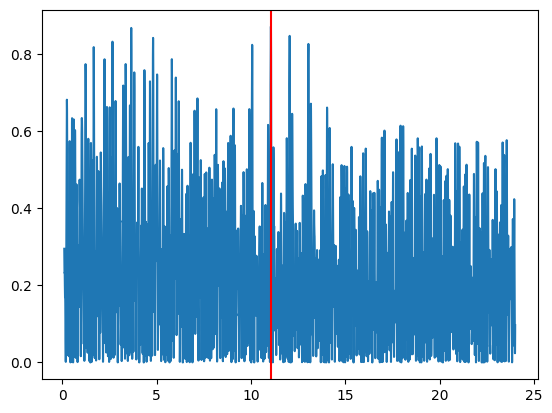

In [143]:
# from 10 days to 1 hour
frequency = np.linspace(0.1, 24, 100000)
power = LombScargle(t, y, yerr, fit_mean=True).power(frequency)
best_frequency = frequency[np.argmax(power)]
plt.plot(frequency, power) 
plt.axvline(best_frequency, color='red')

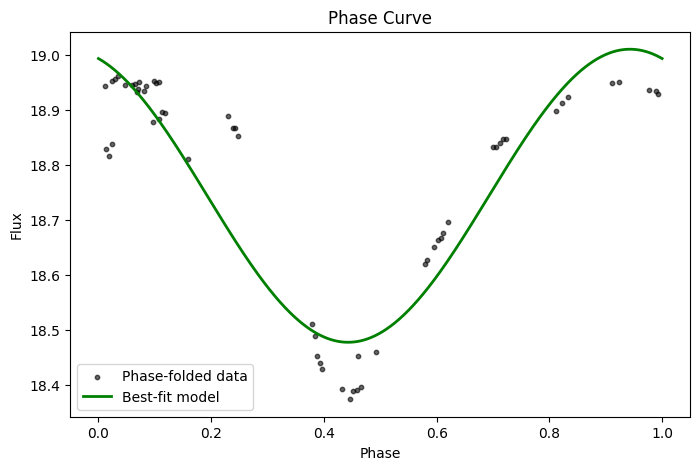

In [144]:
# Given data

# best_frequency = 13.034750645220157
best_period = 1/best_frequency

# Compute phase
phase = (t % best_period) / best_period  # Phase calculation

# Sort phase for smooth plotting
sorted_idx = np.argsort(phase)
phase_sorted = phase[sorted_idx]
y_sorted = y[sorted_idx]

# Fit a model using Lomb-Scargle
ls = LombScargle(t, y, yerr)
phase_fit = np.linspace(0, 1, 1000)  # Smooth phase grid for model
t_fit = phase_fit * best_period  # Convert phase back to time for fitting
y_fit = ls.model(t_fit, 1 / best_period)  # Compute model at these times

# Plot the phase-folded data

# Plot the phase curve
plt.figure(figsize=(8, 5))
plt.scatter(phase_sorted, y_sorted, color='black', alpha=0.6, s=10, label="Phase-folded data")

# Overplot the fitted model
plt.plot(phase_fit, y_fit, color='green', linewidth=2, label="Best-fit model")


# Formatting
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Phase Curve")
plt.legend()
plt.show()

In [55]:
phase_fit

array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [72]:
model = extract_period_rband_box_astropy(band, t, mag, magerr)

0.09960385138686016


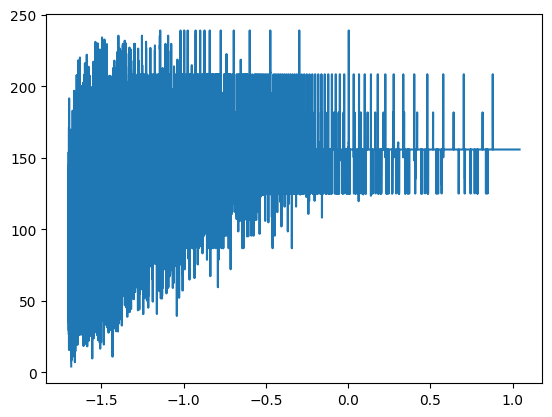

In [55]:
periodogram = model.autopower(0.01, objective="snr")
plt.plot(np.log10(periodogram.period), periodogram.power)

In [38]:
periods = np.linspace(0.05, 1, 1000)
periodogram = model.power(periods, 0.005)

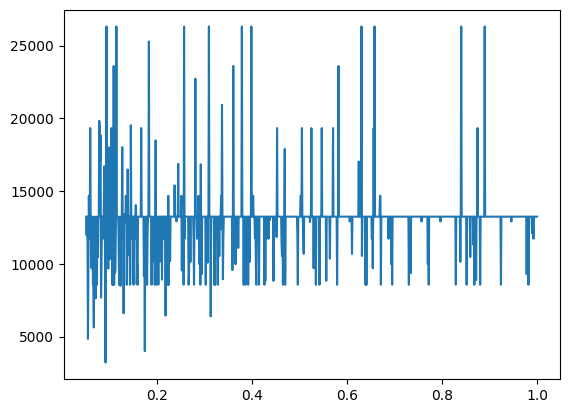

In [39]:
plt.plot(periodogram.period, periodogram.power)

In [29]:
# del extract_period_LS_astropy 
def extract_period_LS_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    r_band = band == 'g'
    t, flux, fluxerr = t[r_band], flux[r_band], fluxerr[r_band]

    # Not enough points in the light curve
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "fs_0": 0.0}

    # No variability in the light curve
    if np.std(flux) <= 0.1:
        return {"period_0": 0.0, "fs_0": 0.0}

    # Light curve is too short
    if np.ptp(t) <= 2.0:
        return {"period_0": 0.0, "fs_0": 0.0}

    frequency = np.linspace(0.1, 24, 100000)
    ls = LombScargle(t, flux, fluxerr, fit_mean=True)
    power = ls.power(frequency)
    best_frequency = frequency[np.argmax(power)]
    fs = ls.false_alarm_probability(power.max())  

    #result = LombScargle(t, flux, fluxerr)
    # idx_period = np.argmax(result.power)
    #return result
    return {"period_0": 1/best_frequency, "fs_0": fs}

In [10]:
src_nested

,objectId,coord_ra,coord_dec,lc,n_lc
npartitions=161,,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<band: [string], midpointMJDTai: [double...",int64
"Order: 7, Pixel: 544",...,...,...,...,...
...,...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...,...


In [30]:
extract_period_LS_astropy(data.lc["band"], data.lc['midpointMJDTai'], data.lc['psfMag'], data.lc['psfMagErr'])

{'period_0': 0.0, 'fs_0': 0.0}

In [31]:
src_nested_w_features = src_nested.reduce(
    extract_period_LS_astropy,
    "lc.band",
    "lc.midpointMJDTai",
    "lc.psfMag",
    "lc.psfMagErr",
    meta={"period_0": float, "fs_0": float},
    append_columns=True,
)

In [42]:
%%time
# Look for periods around half a day, select for high periodogram S/N
src_nested_periodic_cand = src_nested_w_features.query(
    "fs_0 < 0.000000001 & fs_0 > 0"
)

CPU times: user 10.2 ms, sys: 1.6 ms, total: 11.8 ms
Wall time: 10.6 ms


In [43]:
cand_subset = src_nested_periodic_cand.compute()

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:140: RuntimeWarning: invalid value encountered in scalar power
  return (1 - z) ** (0.5 * Nk)
/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:327: RuntimeWarning: overflow encountered in expm1
  return -np.expm1(-tau) + fap_s * np.exp(-tau)
/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:327: RuntimeWarning: overflow encountered in exp
  return -np.expm1(-tau) + fap_s * np.exp(-tau)
/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in scalar power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statisti

In [44]:
cand_subset

,objectId,coord_ra,coord_dec,lc,n_lc,period_0,fs_0
_healpix_29,,,,,,,
1450088555992138467,2430400084454681998,94.933621,-25.316375,band midpointMJDTai psfFlux psfFlu...,156,0.042122,6.229367e-10
1450088555992138473,2429920697384971639,94.933621,-25.316375,band midpointMJDTai psfFlux psfFlu...,156,0.042122,6.231456e-10
1450131236226160761,2334021293210349897,95.302355,-25.274305,band midpointMJDTai psfFlux psfFl...,101,0.122450,3.577134e-18
1450131236226160761,2430386890315148997,95.302355,-25.274305,band midpointMJDTai psfFlux psfFl...,101,0.122450,3.577077e-18
1450131236226160761,2430391288361660966,95.302355,-25.274305,band midpointMJDTai psfFlux psfFl...,107,0.122458,3.890841e-19
...,...,...,...,...,...,...,...
2528756008919062795,2226876084106822802,53.35531,-27.817802,band midpointMJDTai psfFlux psfF...,412,0.166110,8.325084e-11
2528756008920026806,2226876084106835305,53.355358,-27.817752,band midpointMJDTai psfFlux psfF...,442,0.166091,4.210199e-11
2530202551483413150,2226849695827770775,52.664024,-27.927227,band midpointMJDTai psfFlux psfFlu...,139,0.331584,1.026025e-17


In [46]:
cand_subset_sorted = cand_subset.sort_values(by="fs_0", ascending=True)

In [47]:
cand_subset_sorted

,objectId,coord_ra,coord_dec,lc,n_lc,period_0,fs_0
_healpix_29,,,,,,,
1456145241786552406,2430439666873285985,95.124184,-25.043288,band midpointMJDTai psfFlux psfFl...,251,0.235464,1.248079e-56
1456145241786552406,2430483647338388640,95.124184,-25.043288,band midpointMJDTai psfFlux psfFl...,246,0.235477,1.266733e-56
2415759959093272978,1053006683967599766,58.835057,-48.791216,band midpointMJDTai psfFlux psfF...,228,1.445567,6.215969e-50
1456145241786552406,2430479249291877722,95.124184,-25.043288,band midpointMJDTai psfFlux psfFl...,211,0.235477,3.785164e-46
1456145241786552406,2430435268826776048,95.124184,-25.043288,band midpointMJDTai psfFlux psfFl...,211,0.235477,3.788487e-46
...,...,...,...,...,...,...,...
2415664698497860254,1052958305455966443,59.006167,-48.935,band midpointMJDTai psfFlux psfFlu...,185,0.052336,9.862642e-10
2528688955485685299,2226752938804511832,53.015139,-28.315179,band midpointMJDTai psfFlux psfFlu...,616,0.399303,9.886795e-10
1456140820783622679,2334025691256865888,94.985381,-25.195585,band midpointMJDTai psfFlux psfFlu...,222,0.042134,9.921998e-10


2430439666873285985
2430483647338388640
1053006683967599766
2430479249291877722
2430435268826776048
2226757336851037841
2132573170815744796
2132995383280815143
2132990985234301955
2429969075896596882
2429969075896585334
1052962703502495726
1053050664432710947
1053046266386197362
1053002285921096340
1053046266386198164
1053006683967587783
1053046266386207489
1053046266386204212
1053050664432710945


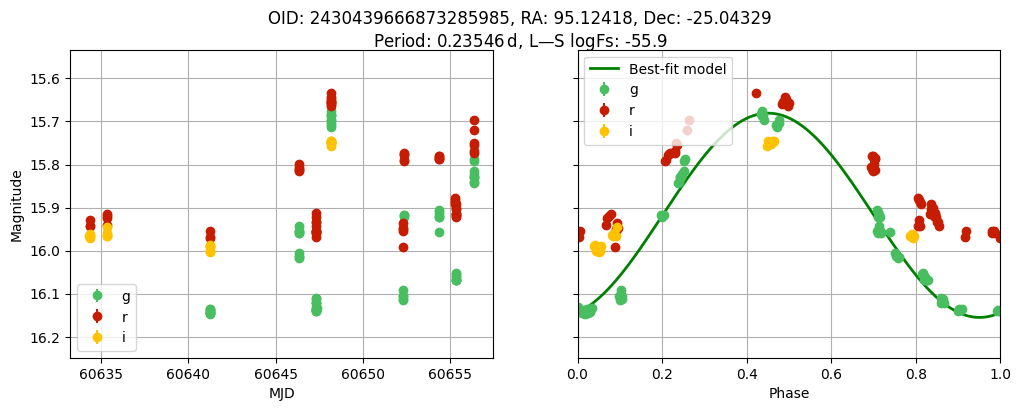

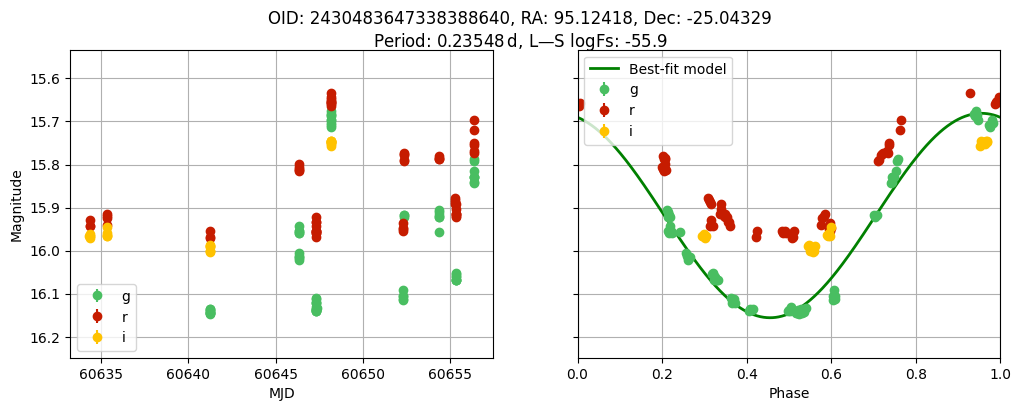

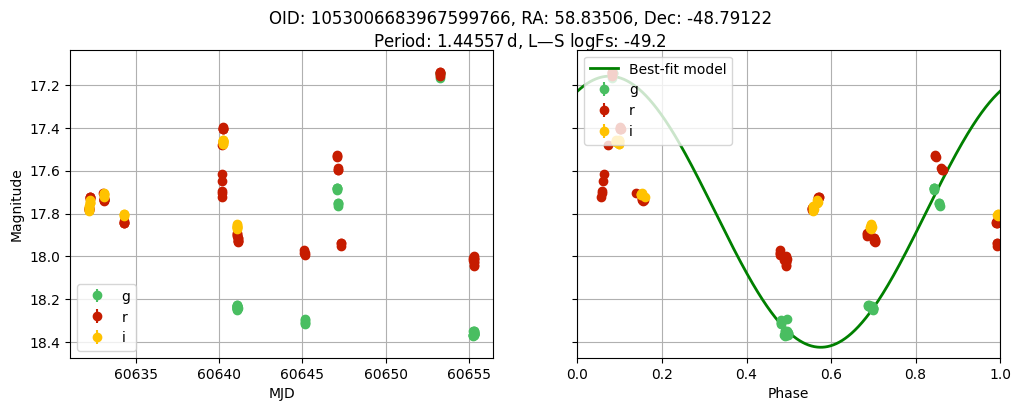

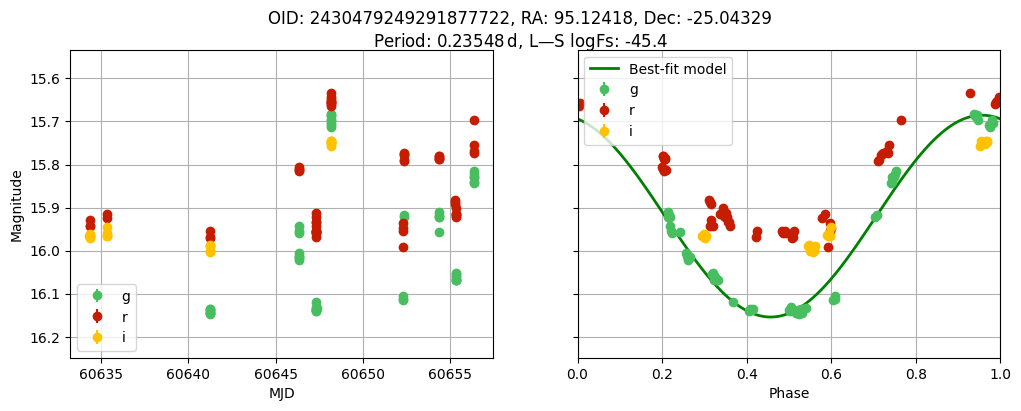

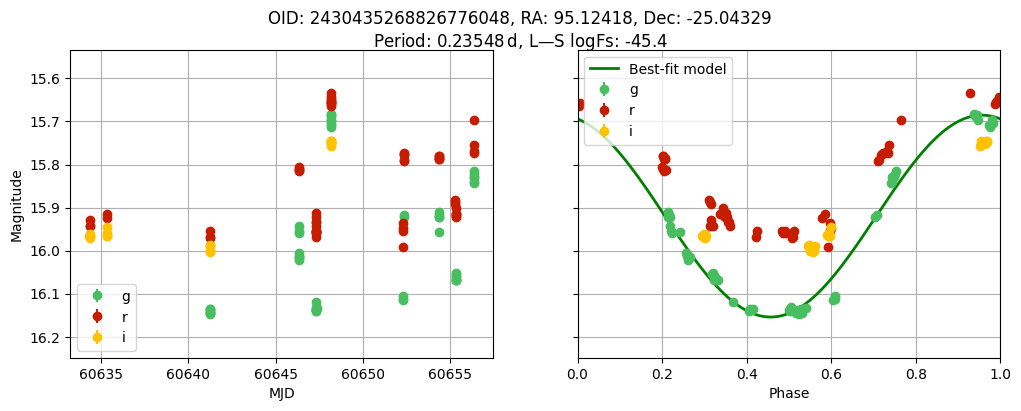

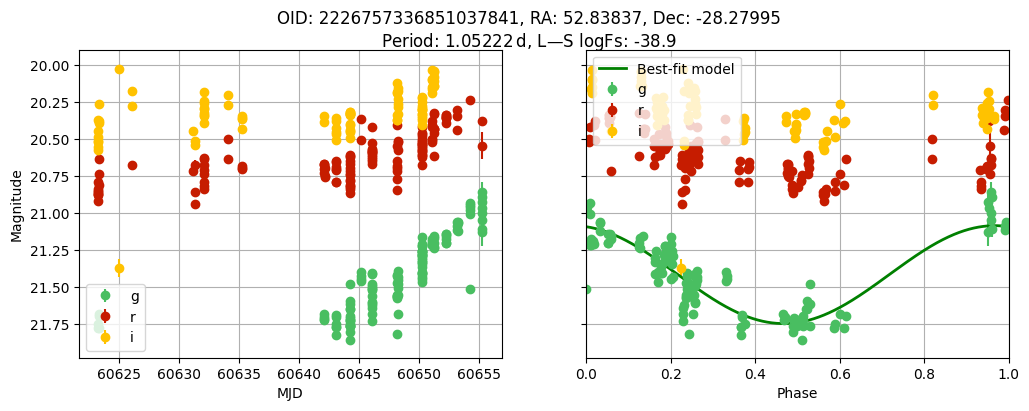

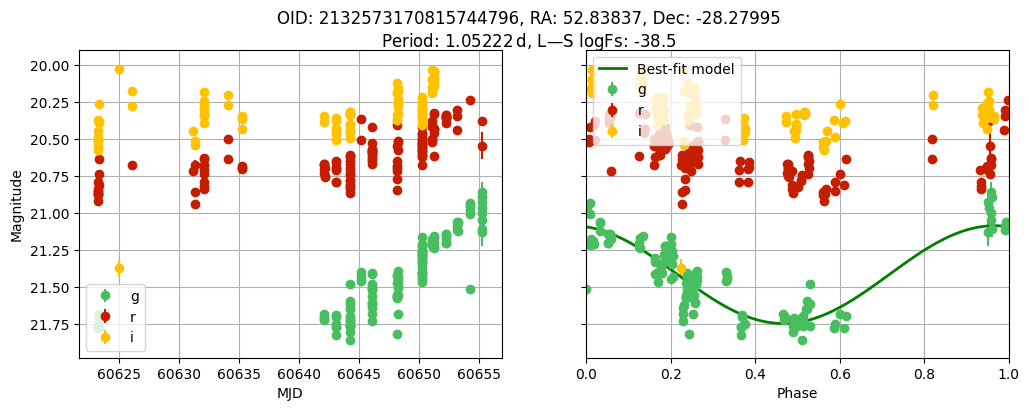

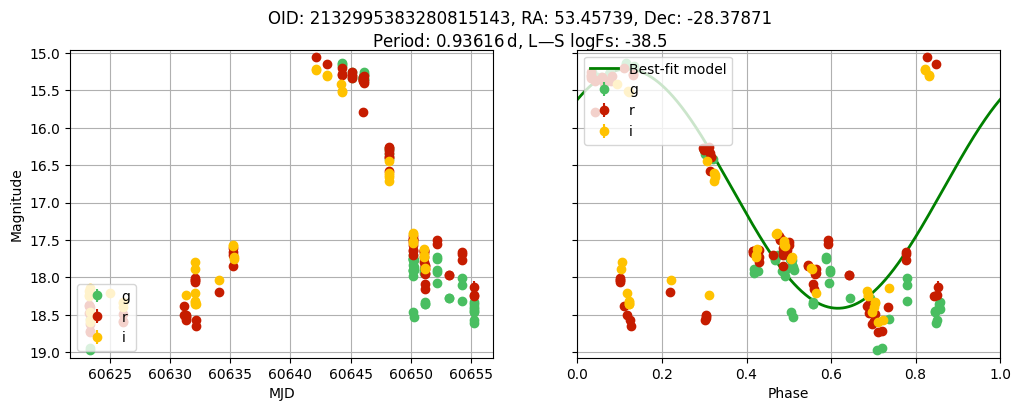

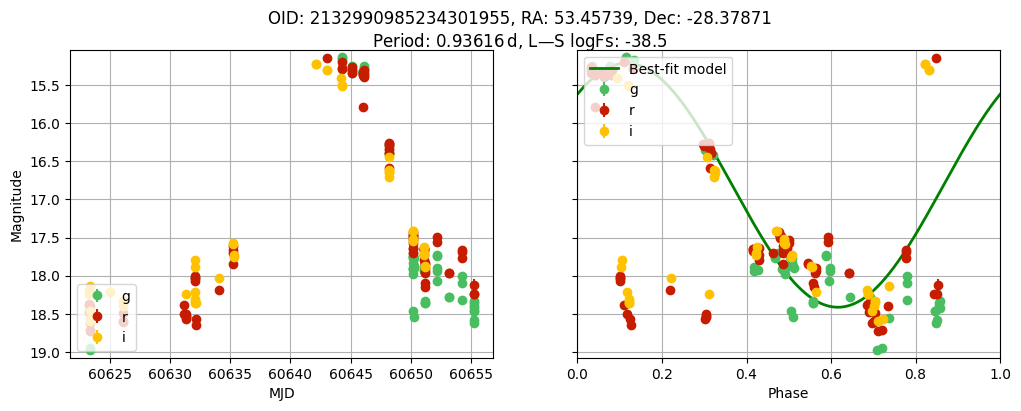

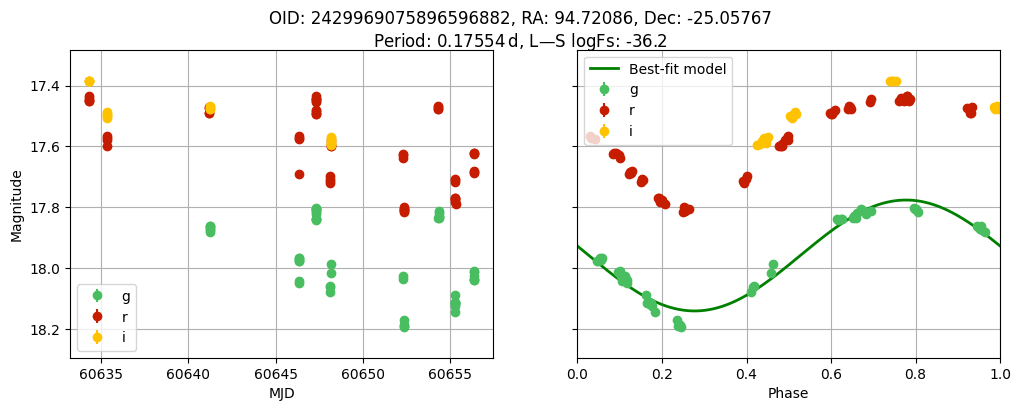

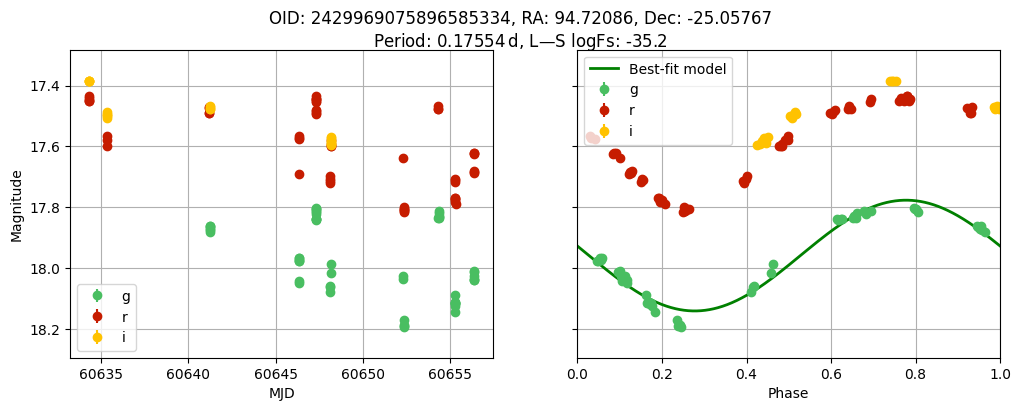

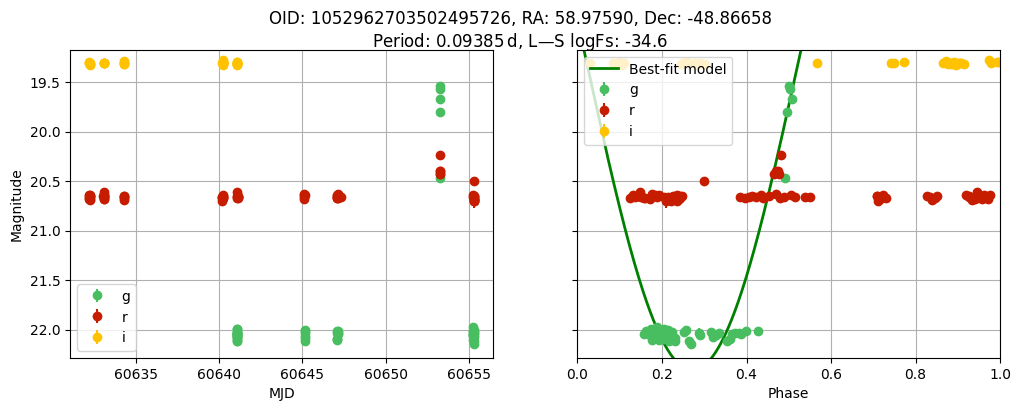

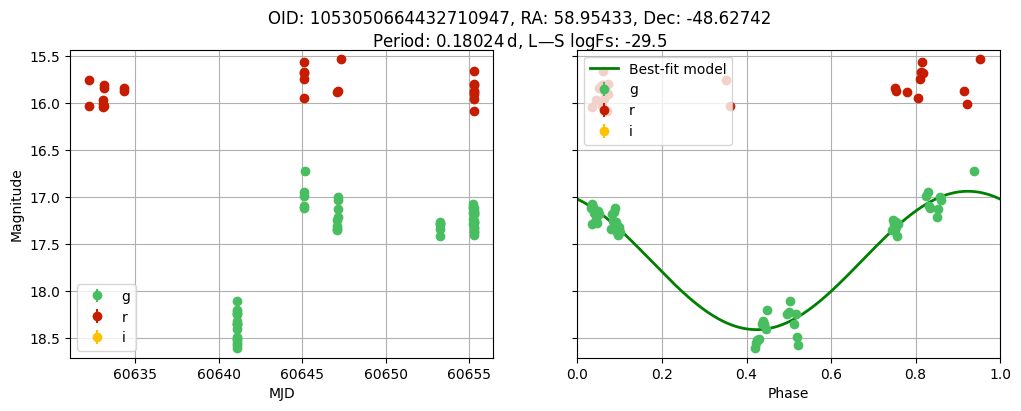

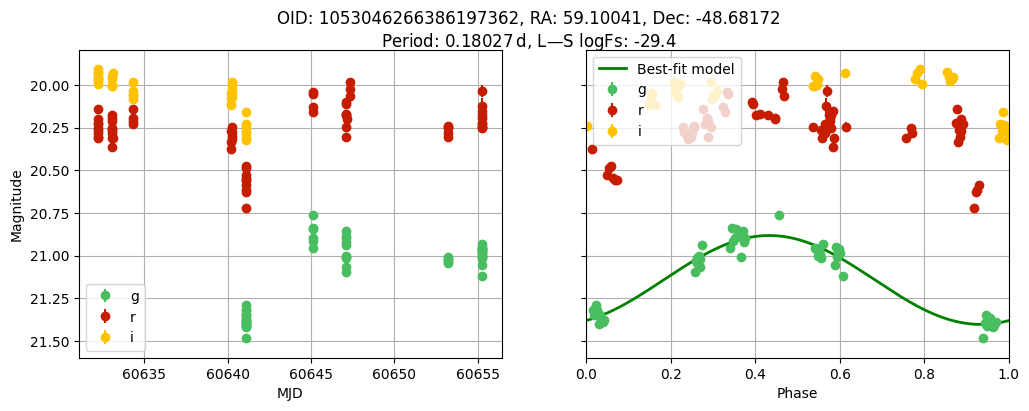

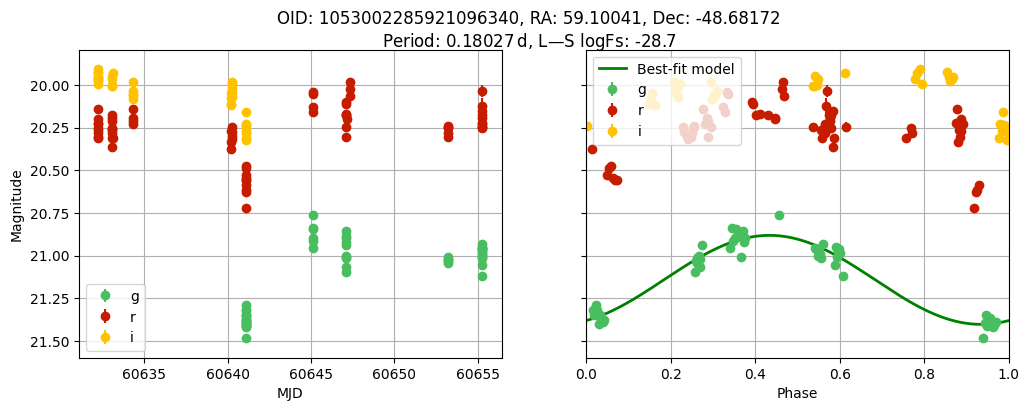

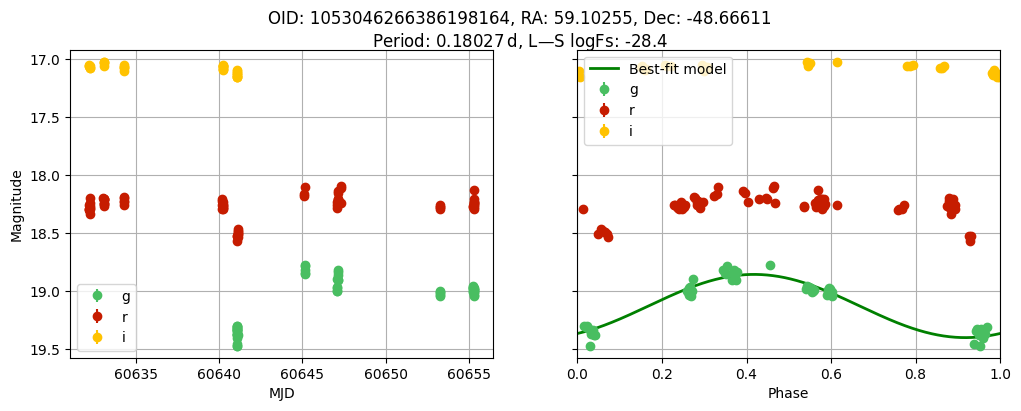

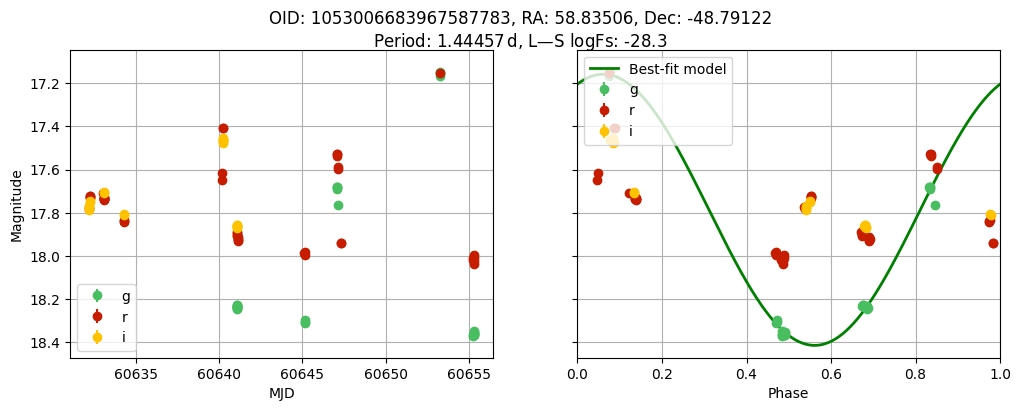

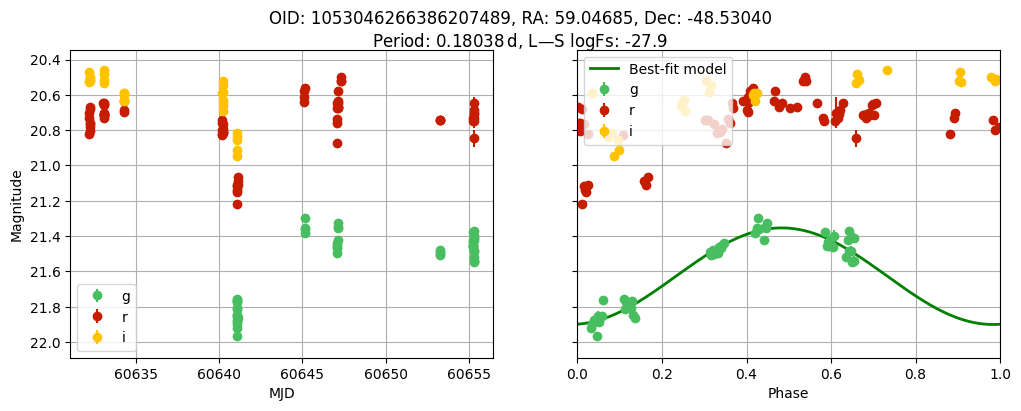

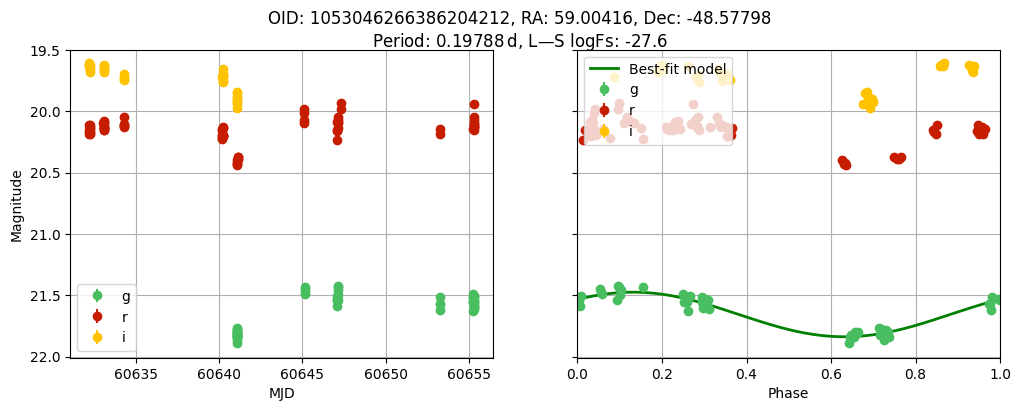

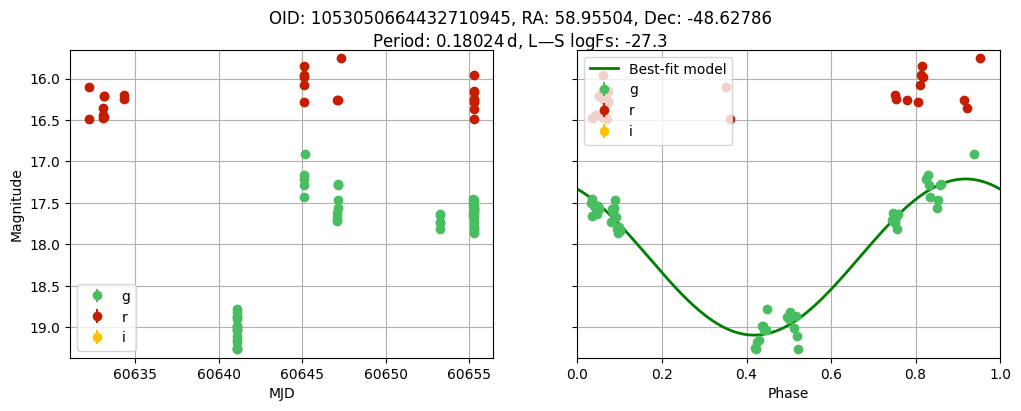

In [65]:
FOLDED = True
BANDS = 'gri'

for healpix29, cand in cand_subset_sorted.iloc[:20].iterrows():
    phase = cand.lc["midpointMJDTai"] % cand["period_0"] / cand["period_0"]
    mag = cand.lc["psfMag"]
    magerr = cand.lc["psfMagErr"]
    
    fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    # Plot data for each band
    for b in BANDS:
        idx = (cand.lc["band"] == b) & (magerr < 0.1)
        ax_mjd.errorbar(
            cand.lc["midpointMJDTai"][idx], mag[idx], yerr=magerr[idx],
            fmt="o", color=COLORS[b], label=b, alpha=1
        )
        ax_phase.errorbar(
            phase[idx], mag[idx], yerr=magerr[idx],
            fmt="o", color=COLORS[b], label=b, alpha=1
        )

    # Fit Lomb-Scargle model only to 'g' band
    idx_g = (cand.lc["band"] == 'g')
    t = cand.lc["midpointMJDTai"][idx_g]
    y = mag[idx_g]
    yerr = magerr[idx_g]
    
    if len(t) > 0:  # Ensure data exists before fitting
        ls = LombScargle(t, y, yerr)
        best_period = cand["period_0"]
        phase_fit = np.linspace(0, 1, 1000)  # Smooth phase grid for model
        t_fit = phase_fit * best_period  # Convert phase back to time for fitting
        y_fit = ls.model(t_fit, 1 / best_period)  # Compute model at these times

        # Overplot the best-fit model on phase-folded plot
        ax_phase.plot(phase_fit, y_fit, color='green', linewidth=2, label="Best-fit model")
        t_fit_mjd = np.arange(np.min(cand.lc["midpointMJDTai"]), np.max(cand.lc["midpointMJDTai"]), 0.01)
        y_fit_mjd = ls.model(t_fit_mjd, 1 / best_period)  # Compute model at these times
        # Overplot the best-fit model on the original time domain (ax_mjd) with low alpha
        # ax_mjd.plot(t_fit_mjd, y_fit_mjd, color='green', linestyle="--", alpha=0.5, linewidth=2, label="Best-fit model (g)")

    # Set plot titles and labels
    fig.suptitle(
        f"OID: {cand.objectId}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
        f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S logFs: {np.log10(cand['fs_0']):.1f}"
    )
    
    ax_mjd.set_ylabel("Magnitude")  
    ax_mjd.set_xlabel("MJD")
    ax_phase.set_xlabel("Phase")
    ax_phase.set_xlim(0, 1)

    # Adjust y-axis limits **only based on g, r, i bands**
    valid_idx = (cand.lc["band"].isin(list(BANDS))) & (magerr < 0.1)
    ymin, ymax = np.min(mag[valid_idx] - magerr[valid_idx]), np.max(mag[valid_idx] + magerr[valid_idx])
    ax_mjd.set_ylim(ymax + 0.1, ymin - 0.1)  # Inverted for magnitude scale

    ax_mjd.legend(loc='lower left')
    ax_phase.legend(loc='upper left')
    ax_mjd.grid()
    ax_phase.grid()
    
    plt.savefig(f"periodic_cand-{release}-{cand.objectId}.pdf")
    print(cand.objectId)